In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.inference import DBNInference

from models.model_v0 import DumbDiscretizer, pgmpy_friendly_transformer, CustomDBNInference

c:\Users\victo\anaconda3\envs\TimeSeries\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# I. General settings

In [2]:
# load data parameters 
countries = ['France', 'Germany', 'United Kingdom', 'Italy', 'Spain', 'Japan', 
             'Sweden', 'Switzerland', 'Belgium', 'Australia', 'Austria', 'China', 
             'Croatia', 'Finland', 'Greece', 'India', 'New Zealand', 
             'Russia', 'Poland']
columns = ['year', 'population', 'gdp', 'energy_per_capita', 'country']

test_countries = ['France', 'Germany', 'United Kingdom', 'Italy', 'Poland']

# preprocessing parameters
split_year = 2003  # trainset until split_year
sliding_window = 2
# define discretization strategy
nb_classes = {  # nb of classes for each variable
    "gdp_per_capita_stationary": 10,  
    "population_stationary": 10, 
    "energy_cons_stationary": 5
}

# model parameters


# II. Load data

### Load raw data 

In [3]:
all_data = pd.read_csv("data/WorldEnergyConsumption.csv")
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22012 entries, 0 to 22011
Columns: 129 entries, country to wind_share_energy
dtypes: float64(126), int64(1), object(2)
memory usage: 21.7+ MB


### Select columns

In [4]:
data = all_data[columns]
data.describe()

,year,population,gdp,energy_per_capita
count,22012.000000,1.812300e+04,1.111300e+04,10602.000000
mean,1974.213247,1.053096e+08,3.585114e+11,25742.760033
std,35.058653,4.640460e+08,2.411179e+12,36122.506628
min,1900.000000,1.833000e+03,1.642060e+08,0.000000
25%,1946.000000,1.712404e+06,1.365898e+10,3101.076250
50%,1984.000000,6.991543e+06,4.167411e+10,13597.986000
75%,2003.000000,2.557688e+07,1.744295e+11,36847.052500
max,2022.000000,7.975105e+09,1.136302e+14,657539.188000


In [5]:
data[data.country=='Poland']

,year,population,gdp,energy_per_capita,country
16332,1900,24312686.0,6.682500e+10,NaN,Poland
16333,1901,24489736.0,NaN,NaN,Poland
16334,1902,24665156.0,NaN,NaN,Poland
16335,1903,24838911.0,NaN,NaN,Poland
16336,1904,25013887.0,NaN,NaN,Poland
...,...,...,...,...,...
16450,2018,38521464.0,1.053479e+12,31661.174,Poland
16451,2019,38493600.0,NaN,30777.799,Poland
16452,2020,38428368.0,NaN,29514.133,Poland
16453,2021,38307724.0,NaN,32001.074,Poland


### Select countries

In [6]:
data = data.loc[data.country.isin(countries)]
data.dropna(inplace=True)  # drop all nan values
data.sample(5)

,year,population,gdp,energy_per_capita,country
4924,2013,4.308854e+06,7.747952e+10,22296.646,Croatia
18869,2009,7.734402e+06,4.349436e+11,46436.273,Switzerland
16397,1965,3.122409e+07,1.886996e+11,24854.314,Poland
4375,1992,1.183813e+09,3.755037e+12,7411.395,China
18838,1978,6.281527e+06,1.656524e+11,45847.062,Switzerland


In [7]:
# rescale data 
data['gdp'] /= 1e12
data['population'] /= 1e7

# create gdp_per_capita and energy_cons

data['gdp_per_capita'] = data['gdp']/data['population']
data['energy_cons'] = data['energy_per_capita']*data['population']

# III. Preprocessing 

### Stationarization 

Fonction permettant de stationariser les time series:

In [8]:
def stationarize(input_df: pd.DataFrame):
    """
    Given data corresponding to only one country, 
    create new columns for time series stationarization.

    :params input_df: pd.DataFrame
        Dataframe of a ocuntry with at least gdp, energy_per_capita and 
        population columns 

    :return pd.DataFrame
    """
    # copy input dataframe 
    df = input_df.copy()

    # stationarisation of gdp 
    df['log_gdp'] = df['gdp_per_capita'].apply(lambda x: np.log(x))
    df['gdp_order_1'] = df['log_gdp'] - df['log_gdp'].shift()
    df['gdp_per_capita_stationary'] = df['gdp_order_1'] - df['gdp_order_1'].shift()

    # stationarization of energy consumption per capita
    df['log_energy'] = df['energy_cons'].apply(lambda x: np.log(x))
    df['energy_cons_order_1'] = df['log_energy'] - df['log_energy'].shift()
    df['energy_cons_stationary'] = df['energy_cons_order_1'] - df['energy_cons_order_1'].shift()
    
    # stationarization of population
    df['log_pop'] = df['population'].apply(lambda x: np.log(x))
    df['population_order_1'] = df['log_pop'] - df['log_pop'].shift()
    df['population_stationary'] = df['population_order_1'] - df['population_order_1'].shift()

    # new create columns 
    new_columns = [
        "gdp_per_capita_stationary", 
        "energy_cons_stationary",
        "population_stationary"
    ]

    # old columns to keep 
    old_cols = ["country", "year"]

    return df[new_columns + old_cols]

In [9]:
# stationarize data 
for i, country in enumerate(countries):
    df_country = stationarize(data[data.country == country])

    if i == 0:
        df_stationary = df_country
    else:
        df_stationary = pd.concat([df_stationary, df_country])

df_stationary.sample(10)

,gdp_per_capita_stationary,energy_cons_stationary,population_stationary,country,year
9233,0.070050,0.000725,-0.000231,India,1967
2356,-0.004418,-0.038112,0.000134,Belgium,1970
7177,0.002738,0.030663,-0.001031,Finland,1968
10020,-0.000044,-0.025384,-0.000408,Italy,2016
18703,NaN,NaN,NaN,Sweden,1966
18723,0.002283,-0.046896,0.000381,Sweden,1986
7793,-0.042614,0.049881,0.000292,Germany,2012
8047,-0.029568,-0.147243,0.000834,Greece,1979
8077,-0.040590,-0.018906,-0.000025,Greece,2009
16413,-0.028982,-0.149671,-0.000183,Poland,1981


Nous devons analyser pourquoi des NaN se glissent dans le dataframe à cette étape (j'y reviens plus tard)

In [10]:
df_stationary[df_stationary.isna()].shape[0]

981

### Train-Test split 

In [11]:
df_test = df_stationary.loc[(df_stationary.country.isin(test_countries)) & (df_stationary.year> split_year)]
df_train = df_stationary[~df_stationary.index.isin(df_test.index)]

print(f"Train size: {df_train.shape[0]}")
print(f"Test size: {df_test.shape[0]}")

Train size: 906
Test size: 75


In [12]:
df_train.dropna(inplace=True)

C:\Users\victo\AppData\Local\Temp\ipykernel_8436\370300940.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.dropna(inplace=True)


### Discretization 

In [13]:
print(f"{df_train[~df_train.isna()].shape[0]} rows without NaN")

868 rows without NaN


In [14]:
df_train

,gdp_per_capita_stationary,energy_cons_stationary,population_stationary,country,year
7299,-0.003909,0.038158,-0.000436,France,1967
7300,-0.001252,-0.007915,-0.000756,France,1968
7301,0.024484,0.043035,-0.000609,France,1969
7302,-0.011263,-0.014586,-0.000141,France,1970
7303,-0.008498,-0.043654,0.000133,France,1971
...,...,...,...,...,...
16431,0.000594,0.023206,-0.000233,Poland,1999
16432,-0.005373,-0.042463,0.004542,Poland,2000
16433,-0.032397,0.055135,0.000216,Poland,2001
16434,0.012262,-0.003852,-0.004504,Poland,2002


In [15]:
# define discretizer object 
discretizer = DumbDiscretizer(df_train, nb_classes=nb_classes)

# indexed dataframe 
df_index = discretizer.df

# print nb of NaN (must be investigated later) and dorp them
print(f"Nb of rows continaing NaN values: {df_index.isna().shape[1]}")
df_index.dropna(inplace=True)
df_index.sample(5)

Nb of rows continaing NaN values: 5


,gdp_per_capita_stationary,energy_cons_stationary,population_stationary,country,year
16402,8,2,4,Poland,1970
9245,2,3,5,India,1979
18834,4,1,4,Switzerland,1974
18705,6,3,4,Sweden,1968
20565,6,3,5,United Kingdom,2000


### PGMPY friendly preprocessing

In [16]:
for i, country in enumerate(countries):

    # select country and relevant columns
    df_country = df_index[df_index.country == country]
    df_country = df_country.drop(["country", "year"], axis=1)
    
    print(f"Country: {country}", df_country.shape)

    # transform in a pgmpy friendly dataframe
    df_pgmpy_country = pgmpy_friendly_transformer(
        df=df_country, 
        sliding_window=sliding_window
    )
    df_pgmpy_country["country"] = country

    if i == 0:
        df_pgmpy = df_pgmpy_country
    else:
        df_pgmpy = pd.concat([df_pgmpy, df_pgmpy_country])

df_pgmpy.reset_index(inplace=True, drop=True)
df_pgmpy.sample(10)

Country: France (37, 3)
Country: Germany (37, 3)
Country: United Kingdom (37, 3)
Country: Italy (37, 3)
Country: Spain (52, 3)
Country: Japan (52, 3)
Country: Sweden (52, 3)
Country: Switzerland (52, 3)
Country: Belgium (52, 3)
Country: Australia (52, 3)
Country: Austria (52, 3)
Country: China (52, 3)
Country: Croatia (27, 3)
Country: Finland (52, 3)
Country: Greece (52, 3)
Country: India (52, 3)
Country: New Zealand (52, 3)
Country: Russia (32, 3)
Country: Poland (37, 3)


,"(gdp_per_capita_stationary, 0)","(energy_cons_stationary, 0)","(population_stationary, 0)","(gdp_per_capita_stationary, 1)","(energy_cons_stationary, 1)","(population_stationary, 1)",country
589,6,2,5,5,1,5,Finland
797,4,3,4,7,2,4,Poland
674,4,2,4,7,2,4,India
56,5,2,5,3,2,5,Germany
299,6,3,4,5,2,4,Switzerland
54,5,3,5,6,2,5,Germany
756,9,3,4,6,3,4,Russia
10,5,2,5,5,3,5,France
352,6,2,5,6,2,5,Belgium
82,6,3,5,7,3,4,United Kingdom


In [17]:
df_pgmpy[df_pgmpy.country == "France"].tail()

,"(gdp_per_capita_stationary, 0)","(energy_cons_stationary, 0)","(population_stationary, 0)","(gdp_per_capita_stationary, 1)","(energy_cons_stationary, 1)","(population_stationary, 1)",country
29,5,3,5,6,2,5,France
30,6,2,5,6,3,5,France
31,6,3,5,5,2,5,France
32,5,2,5,6,2,5,France
33,6,2,5,5,2,5,France


# Model 

### Training 

In [18]:
# build model 
dbn = DBN([
    (("gdp_per_capita_stationary", 0), ("energy_cons_stationary", 0)), 
    (("population_stationary", 0), ("energy_cons_stationary", 0)), 
    (("population_stationary", 0), ("population_stationary", 1)), 
    (("gdp_per_capita_stationary", 0), ("gdp_per_capita_stationary", 1))
])

In [19]:
dbn.fit(df_pgmpy.drop("country", axis=1))

# Inferences 

### Scenarios

In [20]:
'''length = df_test.shape[0]
col_evidence = ["population_stationary", "gdp_per_capita_stationary"]

scenario = {}
for col in col_evidence:
    new_evidence = {(col, i): df_test[df_test.year == split_year+i].iloc[0][col]
                    for i in range(1, length+1)}
    scenario.update(new_evidence)'''

'length = df_test.shape[0]\ncol_evidence = ["population_stationary", "gdp_per_capita_stationary"]\n\nscenario = {}\nfor col in col_evidence:\n    new_evidence = {(col, i): df_test[df_test.year == split_year+i].iloc[0][col]\n                    for i in range(1, length+1)}\n    scenario.update(new_evidence)'

In [21]:
#df_test.head()

In [22]:
# [discretizer.reverse_indexer(column_name="energy_per_capita_stationary", ind=i) 
#  for i in range(10)]

In [23]:
# use custom inference for model test
inference = CustomDBNInference(dbn, discretizer)

results = {}

for test_c in test_countries:
    # create scenario
    length = df_test[df_test.country==test_c].shape[0]
    print('length: ', length)
    col_evidence = ["population_stationary", "gdp_per_capita_stationary"]

    scenario = {}
    for col in col_evidence:
        new_evidence = {(col, i): df_test[(df_test.country==test_c) & (df_test.year == split_year+i)].iloc[0][col]
                        for i in range(1, length+1)}
        scenario.update(new_evidence)

    # provide evidence
    evidence = {
        ("population_stationary", 0): df_train[(df_train.country==test_c)
                                            & (df_train.year == split_year)].iloc[0]["population_stationary"], 
        ("gdp_per_capita_stationary", 0): df_train[(df_train.country==test_c)
                                        & (df_train.year == split_year)].iloc[0]["gdp_per_capita_stationary"], 
    }

    scenario.update(evidence)

    print("Evidence for {}: ".format(test_c), scenario, "\n")

    # now make a pred of Y at time t (now) till time t+horizon
    pred_seq = inference.make_pred("energy_cons_stationary",
                                forecast_step=length+1, 
                                evidence=scenario, 
                                method="PM", 
                                verbose=False)

    # get actual values model should have predicted 
    actual_seq =  list(df_test[df_test.country==test_c].energy_cons_stationary)

    print("Actual seq: ", actual_seq)
    print("Pred seq: ", pred_seq[1:])

    mae = np.mean(np.abs(np.array(actual_seq) - np.array(pred_seq[1:])))

    results[test_c] = {'actual seq': actual_seq, 'pred seq': pred_seq[1:], 'MAE': mae}



length:  15
Evidence for France:  {('population_stationary', 1): 0.00037558684041294477, ('population_stationary', 2): 0.000314842464187004, ('population_stationary', 3): 7.78803247201143e-05, ('population_stationary', 4): -2.6242999664916056e-05, ('population_stationary', 5): -0.00034611827335040424, ('population_stationary', 6): -0.00035148578856913915, ('population_stationary', 7): -0.00037263966111078517, ('population_stationary', 8): -0.00035917181741518256, ('population_stationary', 9): -0.000575616487483277, ('population_stationary', 10): -0.0005330375646428465, ('population_stationary', 11): -0.0001817001939696805, ('population_stationary', 12): -0.0005179239222476983, ('population_stationary', 13): -0.0006637962431961242, ('population_stationary', 14): -0.00039411661708799173, ('population_stationary', 15): -0.0003332842007481851, ('gdp_per_capita_stationary', 1): 0.01894306889113606, ('gdp_per_capita_stationary', 2): -0.011872922461167446, ('gdp_per_capita_stationary', 3): 0.

c:\Users\victo\anaconda3\envs\TimeSeries\Lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:796: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi1.values
c:\Users\victo\anaconda3\envs\TimeSeries\Lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:488: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()


Actual seq:  [-0.002072959410380548, -0.014043682580075156, -0.002175666384149011, -0.009624287668037468, 0.020780084766126805, -0.06051433032791209, 0.08711974092651253, -0.06897687044454592, 0.03886921185156211, 0.009809457980178848, -0.052512764174075244, 0.04932117807189229, -0.023545907973398172, 0.009922338469685599, 0.025787546405076966]
Pred seq:  [-0.005543806950721817, -0.00907311858633315, -0.005543806950721817, -0.0008459148155679028, -0.0008459148155679046, -0.02216040478965007, 0.027366487411750816, 0.007244747719693289, -0.0008459148155679098, 0.007244747719693294, -0.0008459148155679046, 0.007244747719693294, -0.0008459148155679046, 0.007244747719693294, -0.0008459148155679046]
length:  15
Evidence for Germany:  {('population_stationary', 1): 0.00020139907879279662, ('population_stationary', 2): 0.00031469517854088025, ('population_stationary', 3): 0.0002478255620368408, ('population_stationary', 4): 0.0004971864576495122, ('population_stationary', 5): 0.000340373224910

In [24]:
test_country = 'Poland'

54 54 39


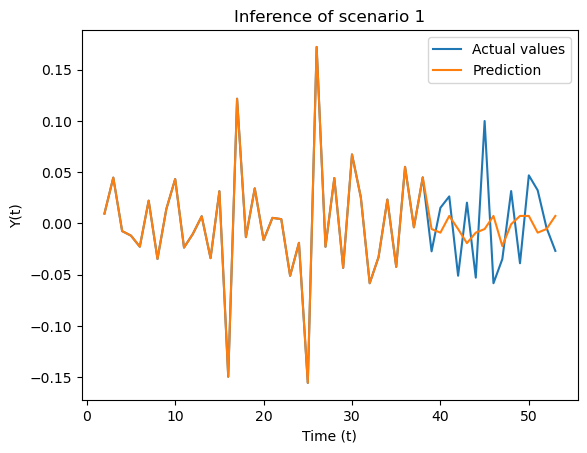

In [25]:
# get sequences for comparison
past_seq = df_stationary[(df_stationary.country == test_country)
                         & (df_stationary.year <= split_year)].energy_cons_stationary.to_list()
all_pred_seq = np.array(past_seq + results[test_country]['pred seq']) 
all_actual_seq = np.array(past_seq + results[test_country]['actual seq'])

nb_points = all_actual_seq.shape[0]
x_ = pd.unique(df_stationary.year)
print(len(x_), all_pred_seq.shape[0], len(past_seq))

# get curves on a sampe plot
plt.plot(np.arange(nb_points), all_actual_seq, label="Actual values")
plt.plot(np.arange(nb_points), all_pred_seq, label="Prediction")

plt.title("Inference of scenario 1")
plt.xlabel("Time (t)")
plt.ylabel("Y(t)")
plt.legend()
plt.show()

In [26]:
def reconstruct_signal(pred, past):
    """
    """
    true_pred = np.zeros_like(pred, dtype=np.float32)
    for i, val in np.ndenumerate(pred):

        x, y = past[-2:]

        new_y = np.exp(val - np.log(x) + 2*np.log(y))
        true_pred[i] = new_y
        
        past = np.hstack([past, new_y])

    past_array = np.array(past)
    return past_array

# Comparison with ARIMA model

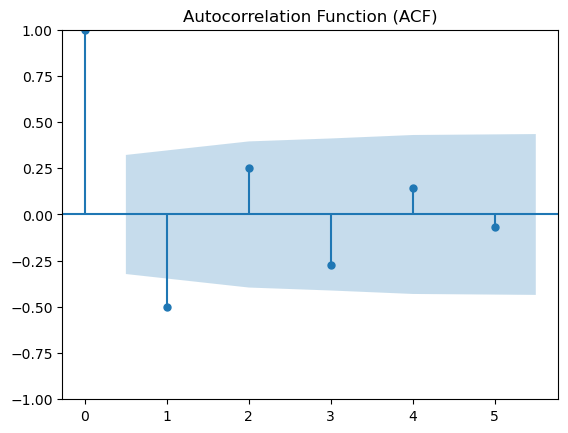

In [27]:
#
ts_stationary = df_stationary[df_stationary.country == test_country]
ts_stationary.set_index("year", inplace=True, drop=True)
ts_stationary = ts_stationary[["energy_cons_stationary"]]
ts_stationary.dropna(inplace=True)

plot_acf(ts_stationary[ts_stationary.index <= split_year], lags=5)
plt.title('Autocorrelation Function (ACF)')
plt.show()

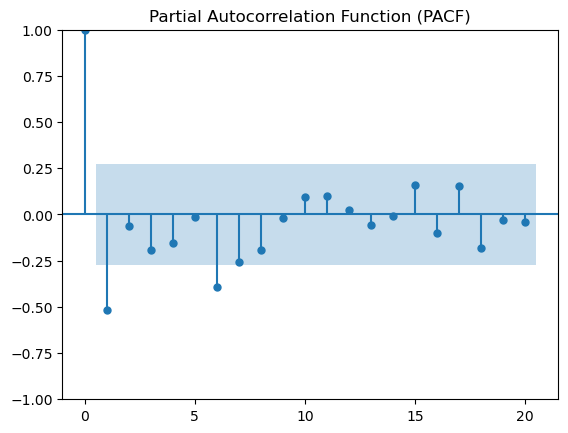

In [28]:
plot_pacf(ts_stationary[ts_stationary <= split_year], lags=20)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [29]:
# Replace p, d, q values with the parameters determined from ACF and PACF plots
p = 1  # AR order
d = 0  # differencing order (set to 0 for stationary data)
q = 2  # MA order
model = ARIMA(ts_stationary[ts_stationary <= split_year], order=(p, d, q))
results = model.fit()

# Summary of the ARIMA model
print(results.summary())

# Forecast future values
forecast_steps = length  # Number of steps ahead to forecast
forecast = results.forecast(steps=forecast_steps)

ts_stationary["pred_arima"] = list(ts_stationary[ts_stationary.index <= split_year].values) + list(forecast)

c:\Users\victo\anaconda3\envs\TimeSeries\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\victo\anaconda3\envs\TimeSeries\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\victo\anaconda3\envs\TimeSeries\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                 SARIMAX Results                                  
Dep. Variable:     energy_cons_stationary   No. Observations:                   52
Model:                     ARIMA(1, 0, 2)   Log Likelihood                  87.778
Date:                    Tue, 16 Apr 2024   AIC                           -165.557
Time:                            22:46:35   BIC                           -155.801
Sample:                                 0   HQIC                          -161.816
                                     - 52                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.002     -0.349      0.727      -0.004       0.003
ar.L1         -0.9336      0.281     -3.326      0.001      -1.484      -0.383
ma.L1          0.201

c:\Users\victo\anaconda3\envs\TimeSeries\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\victo\anaconda3\envs\TimeSeries\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [30]:
ts_stationary["pred_DBN"] = list(ts_stationary[ts_stationary.index <= split_year].energy_cons_stationary) + list(pred_seq[1:])

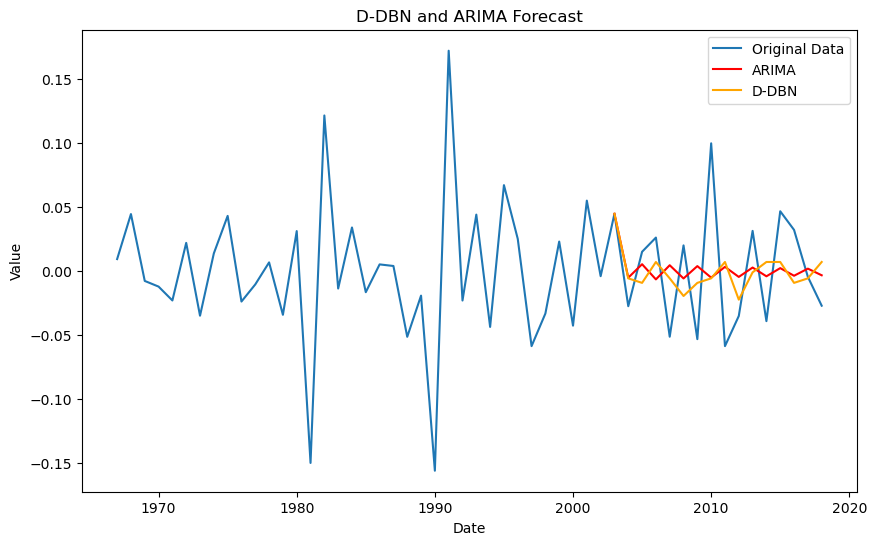

In [40]:
# Plot the original time series and the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(ts_stationary.energy_cons_stationary, label='Original Data')
plt.plot(ts_stationary[ts_stationary.index >= split_year].pred_arima, label='ARIMA', color='red')
plt.plot(ts_stationary[ts_stationary.index >= split_year].pred_DBN, label='D-DBN', color='orange')
plt.title('D-DBN and ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

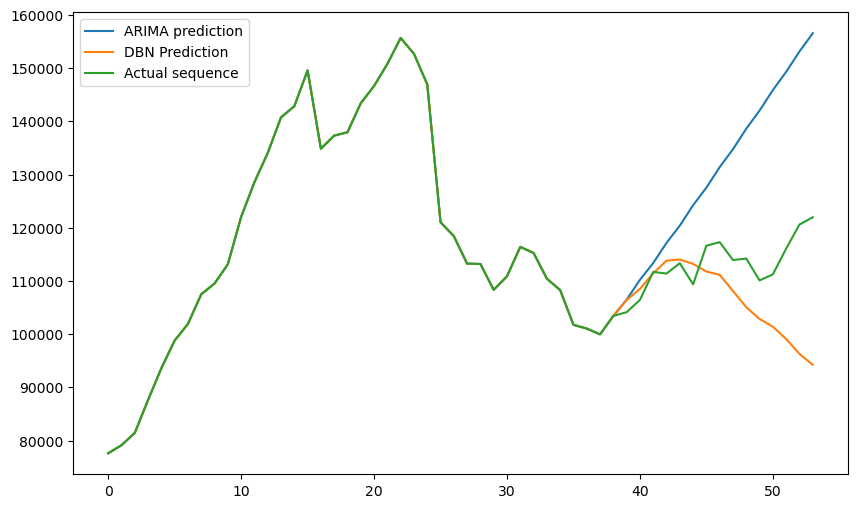

In [38]:
past_seq = list(data[(data.country == test_country)
                     & (data.year <= split_year)].energy_cons)
true_actual = data[(data.country == test_country)].energy_cons.to_numpy()

rec_actual = reconstruct_signal(actual_seq, past_seq)
true_pred_DBN = reconstruct_signal(pred_seq[1:], past_seq)
true_pred_ARIMA = reconstruct_signal(forecast, past_seq)

plt.figure(figsize=(10, 6))
plt.plot(true_pred_ARIMA, label="ARIMA prediction")
plt.plot(true_pred_DBN, label="DBN Prediction")
plt.plot(true_actual, label="Actual sequence")

plt.legend()

## Compute MAE

In [34]:
(np.sum(np.abs(rec_actual - true_pred_ARIMA))/length)/1163

15.627385050075713